# Project: Rental Price Prediction

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#description">Data Description</a></li>
<li><a href="#library">Import Library</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#analysis">Statistical Analysis</a></li>
<li><a href="#model">Building Model</a></li>
<li><a href="#eva">Model Evaluation</a></li>
</ul>

<a id='intro'></a>
## Introduction
Housing costs demand a significant investment from both consumers and developers. And when it comes to planning a budget—whether personal or corporate—the last thing anyone needs is uncertainty about one of their biggets expenses. 

Soviet bank, Russland’s oldest and largest bank, helps their customers by making predictions about realty prices so renters, developers, and lenders are more confident when they sign a lease or purchase a building.

Although the housing market is relatively stable in Russland, the country’s volatile economy makes forecasting prices as a function of apartment characteristics a unique challenge. Complex interactions between housing features such as number of bedrooms and location are enough to make pricing predictions complicated. Adding an unstable economy to the mix means Soviet bank and their customers need more than simple regression models in their arsenal.



<a id='description'></a>
## Data Description
Check the data description document

<a id='library'></a>
## Import Library


In [68]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

import pandas as pd
import numpy as np
import scipy.stats

import sklearn.preprocessing as preproc
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

<a id='wrangling'></a>
# Data Wrangling

In [69]:
df = pd.read_csv('train.csv')
  
d = pd.read_csv('macro.csv')
df = pd.merge(df,d,how = 'inner',on = 'timestamp')

In [70]:
df.shape

(30471, 391)

In [71]:
df.nunique().sort_values(ascending=False)

id                                   30471
big_road2_km                         11852
exhibition_km                        11852
museum_km                            11852
mosque_km                            11852
                                     ...  
baths_share                              2
water_pipes_share                        2
big_road1_1line                          2
mosque_count_1000                        2
provision_retail_space_modern_sqm        1
Length: 391, dtype: int64

### id has high cardinality

In [72]:
df.drop(columns='id',inplace=True)

### Remove columns with high multicolinearity

In [73]:
def chk_multicollinearity(reg_exp,df=df,threshold=.5):
    """
    Remove columns exhibiting multicollinearity based on regular expression pattern.

    Parameters:
    reg_exp (str): Regular expression pattern to match column names.
    df (pd.DataFrame): Input DataFrame containing numeric columns.
    threshold (float, optional): Threshold for determining multicollinearity (default is 0.5).

    Returns:
    pd.DataFrame: DataFrame with multicollinear columns removed.
    
    This function identifies columns in the input DataFrame `df` with names matching the provided
    regular expression pattern `reg_exp`. For each identified column, it computes the correlation
    coefficient with the first column found, and if the correlation coefficient is greater than the
    specified `threshold`, the column is considered multicollinear and removed from the DataFrame.
    The modified DataFrame without the multicollinear columns is returned.
    """
    columns = []
    
    #get the columns that has regular expressions
    for col in df.select_dtypes('number').columns:
        if re.search(reg_exp,col):
            columns.append(col)
    
    # get columns with multicolinearity
    mul_col = []
    for column in columns:
        corr = df[column].corr(df[columns[0]]) 
        if corr > threshold:
            mul_col.append(column)
            
    #drop columns
    df.drop(columns=mul_col,inplace=True)
   
    return df

In [74]:
df = chk_multicollinearity('^cafe_s',df)

In [75]:
df = chk_multicollinearity('^cafe_c',df)
df = chk_multicollinearity('^cafe_a',df)

In [ ]:
df = chk_multicollinearity('^office',df)
df =chk_multicollinearity('^trc',df)
df =chk_multicollinearity('church',df)
df =chk_multicollinearity('mosque',df)
df =chk_multicollinearity('school',df)
df =chk_multicollinearity('leisure',df)
df =chk_multicollinearity('market',df)
df =chk_multicollinearity('sport',df)
df =chk_multicollinearity('prom',df)
df =chk_multicollinearity('rail',df)
df =chk_multicollinearity('block',df)
df =chk_multicollinearity('brick',df)
df =chk_multicollinearity('slag',df)
df =chk_multicollinearity('mix',df)
df =chk_multicollinearity('provision',df)
df =chk_multicollinearity('_male',df)
df =chk_multicollinearity('_female',df)
df =chk_multicollinearity('female',df)
df =chk_multicollinearity('male',df)
df =chk_multicollinearity('green',df)
df =chk_multicollinearity('rent',df)
df =chk_multicollinearity('build_count',df)
df =chk_multicollinearity('metro',df)
df = chk_multicollinearity('rent',df)

In [ ]:
df.columns

### Remove columns with more than 50% null value

In [ ]:
def drop_null(df,threshold=.5):
    """
    Drop features from the DataFrame with missing values exceeding a specified threshold.

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    threshold (float, optional): Threshold for missing values (default is 0.5).

    Returns:
    pd.DataFrame: DataFrame with features having missing values below the specified threshold.
    
    This function removes columns from the input DataFrame `df` where the percentage of missing
    values exceeds the specified `threshold`. Columns with missing values greater than the product
    of `threshold` and the total number of rows are considered, and these columns are dropped from
    the DataFrame. The modified DataFrame with features having missing values below the threshold
    is returned.
    """
    rows = df.shape[0]
    large_null = []
    for col in df.columns:
        missing = df[col].isnull().sum() 
        if missing > rows * threshold:
            large_null.append(col)
    df.drop(columns=large_null,inplace=True)
    return df

In [14]:
df = drop_null(df)

### Checking missing values further

In [65]:
df[['max_floor', 'material','build_year', 'num_room', 'kitch_sq', 'state']].isnull().sum()

max_floor       0
material        0
build_year      0
num_room        0
kitch_sq        0
state         119
dtype: int64

In [66]:
df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,radiation_raion_yes,big_market_raion_yes,nuclear_reactor_raion_yes,detention_facility_raion_yes,water_1line_yes,big_road1_1line_yes,railroad_1line_yes,ecology_good,ecology_poor,ecology_satisfactory
8154,45,27.0,6.0,9.0,1.0,1970.0,2.0,6.0,3.0,8889466.752,...,0,0,0,0,0,0,0,1,0,0
8381,52,33.0,13.0,25.0,2.0,2004.0,2.0,7.0,NaN,7963518.819,...,1,0,1,0,0,0,0,0,0,1
8423,46,29.0,9.0,9.0,2.0,1969.0,2.0,5.0,3.0,7126815.285,...,0,0,1,0,0,0,0,0,1,0
8427,45,29.0,2.0,9.0,1.0,1972.0,2.0,6.0,3.0,7811375.434,...,1,0,0,0,0,0,0,0,0,1
8563,46,45.0,5.0,5.0,1.0,1967.0,2.0,5.0,3.0,8841267.454,...,0,0,1,0,0,0,0,0,1,0


<Axes: >

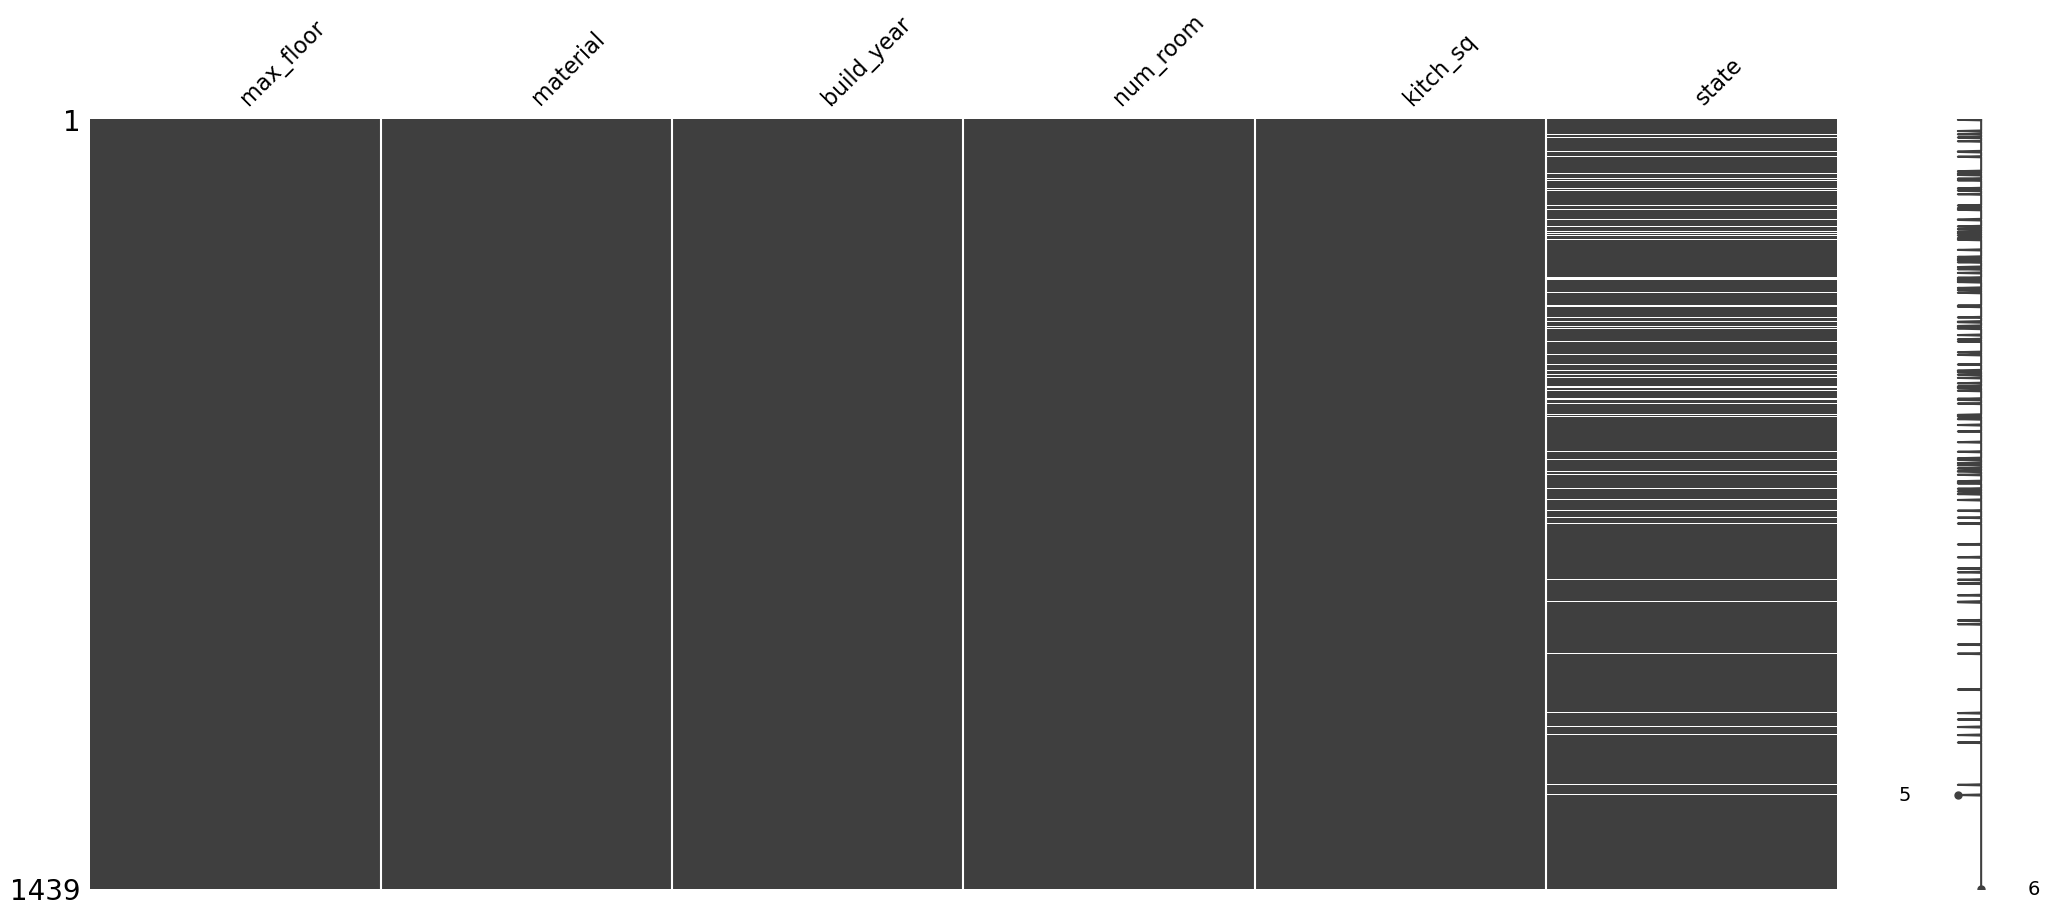

In [67]:
msno.matrix(df[['max_floor', 'material','build_year', 'num_room', 'kitch_sq', 'state']])

In [19]:
def plot_msno(column,df=df):
    
    """
    Visualize missing data pattern for a specific column in the DataFrame using Missingno library.

    Parameters:
    column (str): The column name for which missing data visualization is required.
    df (pd.DataFrame): Input DataFrame containing the specified column.

    Returns:
    list: List of indices with missing values in the specified column.
    
    This function takes a DataFrame `df` and a specific column name `column` as input. It creates a
    Missingno matrix visualization, highlighting missing data patterns for the specified column. The
    function also returns a list of indices where the specified column has missing values, allowing
    further analysis or handling of these missing values.
    """
    
    emp = df[df[column].isnull()].index
    msno.matrix(df.drop(index=emp))
    
    return emp

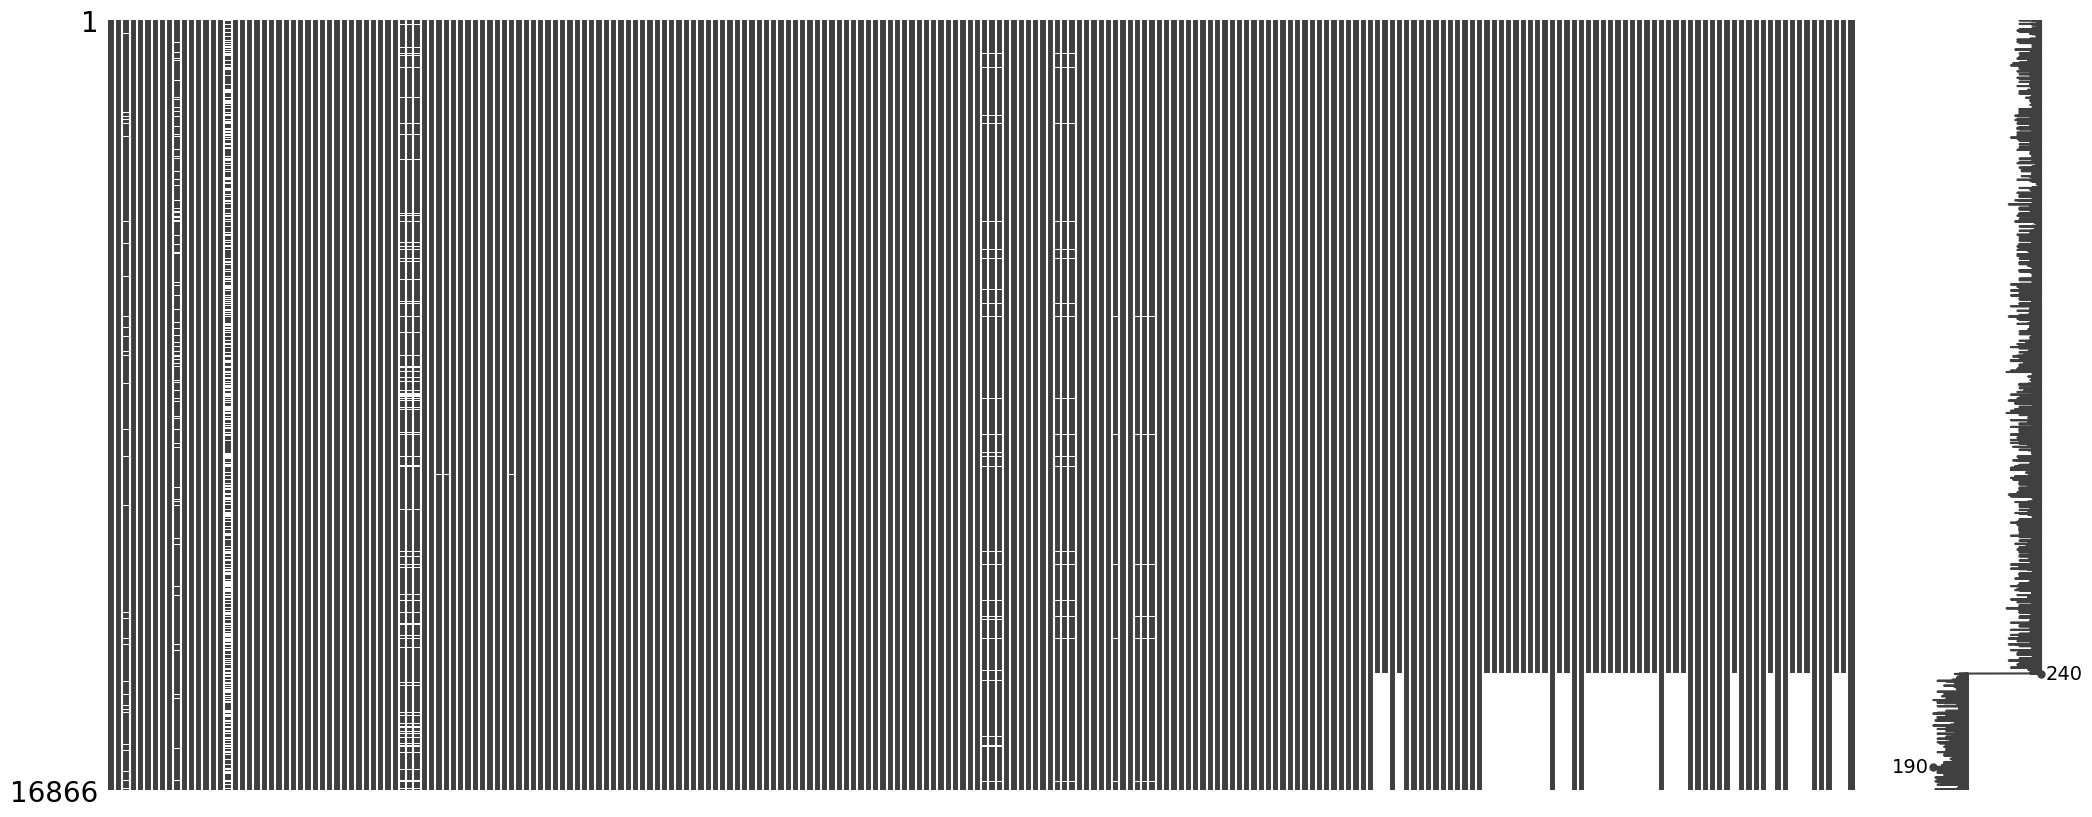

In [20]:
emp_year = plot_msno('build_year')

In [21]:
df = df.drop(index=emp_year)

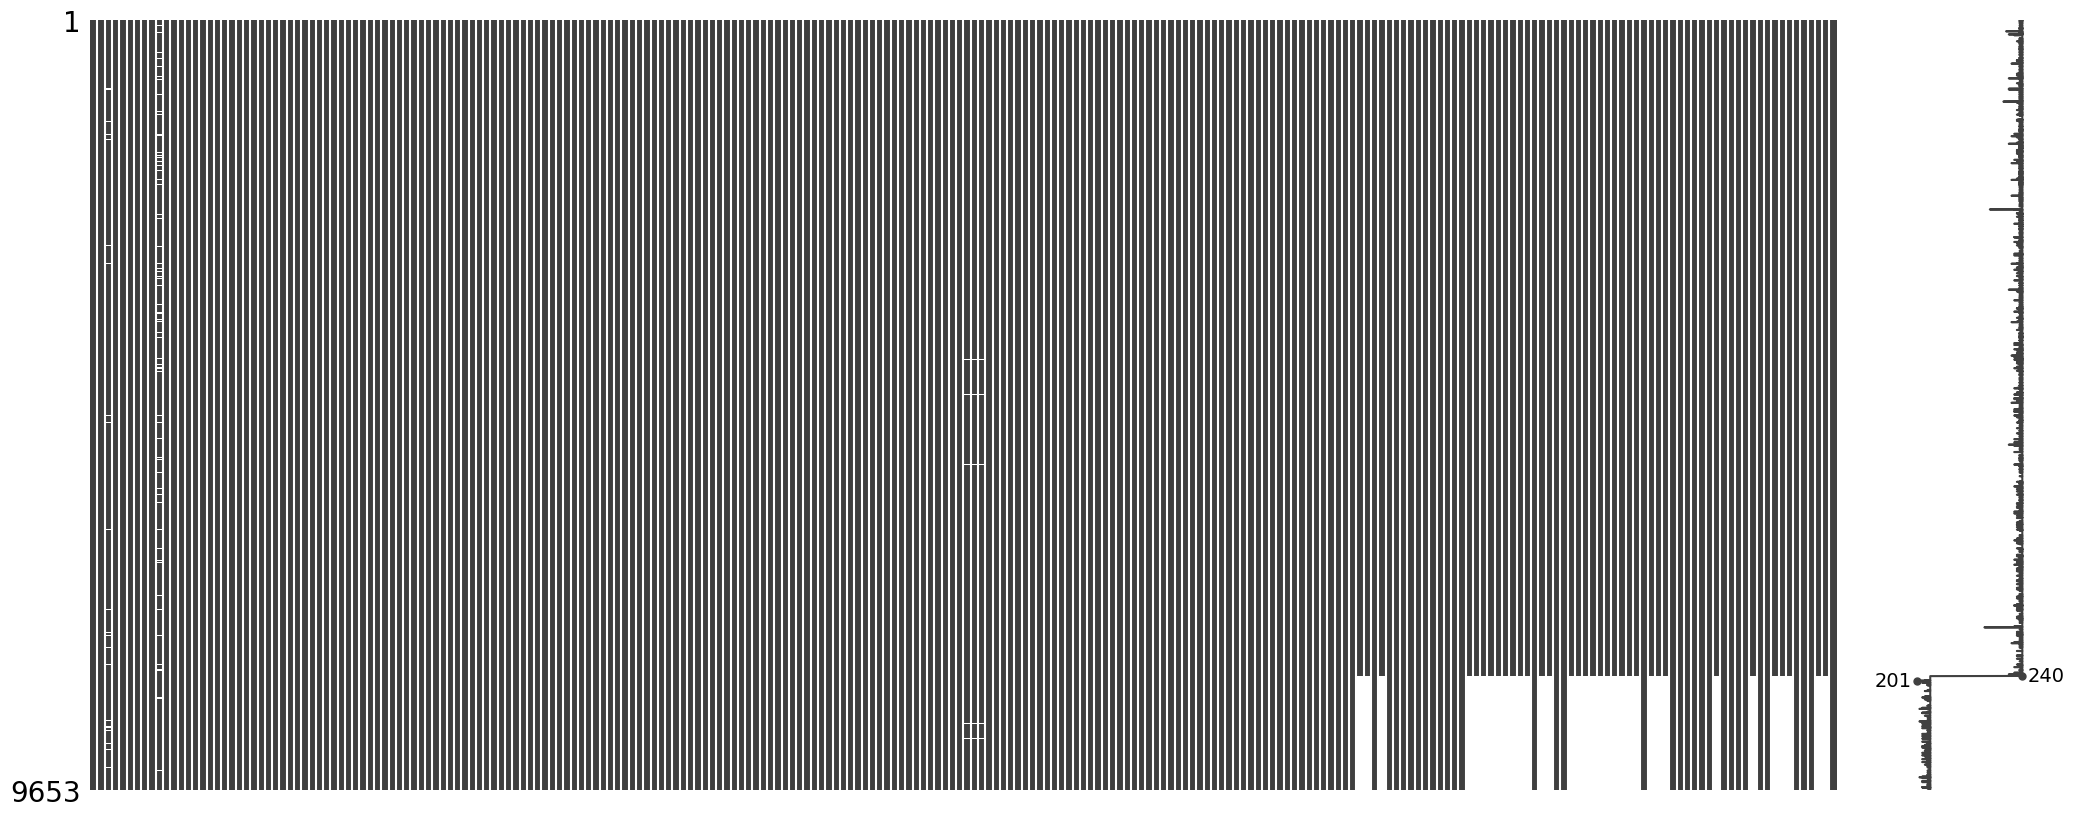

In [22]:
emp_hos = plot_msno('hospital_beds_raion',df=df)
df = df.drop(index=emp_hos)

In [23]:
df.isnull().sum().sort_values(ascending=False).head(50)

child_on_acc_pre_school              1429
divorce_rate                         1429
overdue_wages_per_cap                1429
construction_value                   1429
fin_res_per_cap                      1429
marriages_per_1000_cap               1429
incidence_population                 1429
perinatal_mort_per_1000_cap          1429
infant_mortarity_per_1000_cap        1429
old_house_share                      1429
unprofitable_enterpr_share           1429
heating_share                        1429
electric_stove_share                 1429
hot_water_share                      1429
gas_share                            1429
sewerage_share                       1429
baths_share                          1429
water_pipes_share                    1429
share_own_revenues                   1429
lodging_sqm_per_cap                  1429
housing_fund_sqm                     1429
power_clinics                        1429
apartment_build                      1429
population_reg_sports_share       

In [24]:
df = chk_multicollinearity('grp',df)
df = chk_multicollinearity('share',df)
df = chk_multicollinearity('hospi',df)


In [25]:
df.shape

(9653, 236)

In [26]:
df.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm
count,9653.000000,9340.000000,9653.000000,9653.000000,9653.000000,9.653000e+03,9653.000000,9653.000000,8789.000000,9.653000e+03,...,9653.000000,8224.000000,8224.000000,8224.000000,9653.000000,9653.000000,9653.000000,8224.000000,8224.000000,9653.000000
mean,53.248627,33.135225,6.880348,12.007355,1.964778,3.995055e+03,1.964881,7.132394,2.299579,1.030806e+07,...,7880.579330,60.602140,722.348979,287.652967,10190.795297,0.447774,394243.281881,27.845793,46144.229572,229423.410370
std,22.406053,19.464620,5.008083,6.218001,1.498308,2.040731e+05,0.867585,7.505108,0.823680,6.933260e+06,...,577.930420,33.638922,27.607701,2.973137,455.514558,0.005693,39724.124778,0.637101,115.527609,2497.223746
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,1.000000,2.081628e+06,...,6899.930464,41.900000,707.000000,286.000000,9350.000000,0.439390,329348.000000,26.700000,46080.000000,226047.300000
25%,38.000000,20.000000,3.000000,8.000000,1.000000,1.965000e+03,1.000000,5.000000,2.000000,5.686537e+06,...,7804.909725,41.900000,707.000000,286.000000,10311.000000,0.447840,398451.000000,28.200000,46080.000000,229294.800000
50%,47.000000,30.000000,5.000000,12.000000,1.000000,1.974000e+03,2.000000,7.000000,2.000000,8.841267e+06,...,7804.909725,41.900000,707.000000,286.000000,10311.000000,0.447840,398451.000000,28.200000,46080.000000,229294.800000
75%,63.000000,42.000000,9.000000,17.000000,2.000000,2.000000e+03,3.000000,9.000000,3.000000,1.163805e+07,...,7804.909725,41.900000,707.000000,286.000000,10311.000000,0.447840,398451.000000,28.200000,46080.000000,229294.800000
max,637.000000,637.000000,77.000000,48.000000,6.000000,2.005201e+07,17.000000,620.000000,33.000000,6.197812e+07,...,8846.956102,121.100000,772.000000,293.000000,10805.000000,0.458880,463938.000000,28.200000,46352.000000,234576.900000


### Removing outliers

In [27]:
for col in df.select_dtypes('number'):
    high,maxi =  df[col].quantile([.9,1])
    if maxi > 5 * high:
        low,high = df[col].quantile([0.1,.9])
        df = df[df[col].between(low,high)]

In [28]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm
8154,2013-05-27,45,27.0,6.0,9.0,1.0,1970.0,2.0,6.0,3.0,...,8846.956102,121.1,772.0,293.0,9350.0,0.43939,329348.0,26.7,46352.0,226047.3
8381,2013-06-07,52,33.0,13.0,25.0,2.0,2004.0,2.0,7.0,NaN,...,8846.956102,121.1,772.0,293.0,9350.0,0.43939,329348.0,26.7,46352.0,226047.3
8423,2013-06-10,46,29.0,9.0,9.0,2.0,1969.0,2.0,5.0,3.0,...,8846.956102,121.1,772.0,293.0,9350.0,0.43939,329348.0,26.7,46352.0,226047.3
8427,2013-06-10,45,29.0,2.0,9.0,1.0,1972.0,2.0,6.0,3.0,...,8846.956102,121.1,772.0,293.0,9350.0,0.43939,329348.0,26.7,46352.0,226047.3
8563,2013-06-19,46,45.0,5.0,5.0,1.0,1967.0,2.0,5.0,3.0,...,8846.956102,121.1,772.0,293.0,9350.0,0.43939,329348.0,26.7,46352.0,226047.3


### Getting season and year from timestamp

In [29]:

# Extract months out of the timestamp and split it based on seasons
    
df['month'] = df['timestamp'].str.split('-',expand=True)[1].astype(float)
    
df.loc[(df['month'] >= 3) & (df['month']<= 5) ,'season'] = 'spring'
df.loc[(df['month'] >= 6) & (df['month']<= 8) ,'season'] = 'summer'
df.loc[(df['month'] >= 9) & (df['month']<= 11) ,'season'] = 'fall'
df.loc[(df['month'] == 12) | (df['month']<= 2) ,'season'] = 'winter'

mask_season = {'winter':4,'fall': 3,'summer':2,'spring':1}

df['season'] = df['season'].replace(mask_season)

In [30]:
df['year'] = df['timestamp'].str.split('-',expand=True)[0].astype(float)

df.drop(columns=['timestamp','month'],inplace = True)

### Handling categorical variables

In [31]:
df.select_dtypes('object')

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology,child_on_acc_pre_school,modern_education_share,old_education_build_share
8154,Investment,Severnoe Butovo,no,no,no,no,no,no,no,no,no,no,no,no,good,"3,013","90,92","23,14"
8381,Investment,Shhukino,no,no,no,no,yes,no,no,yes,no,no,no,no,satisfactory,"3,013","90,92","23,14"
8423,Investment,Dmitrovskoe,no,yes,no,no,no,no,no,yes,no,no,no,no,poor,"3,013","90,92","23,14"
8427,Investment,Kon'kovo,no,no,no,no,yes,no,no,no,no,no,no,no,satisfactory,"3,013","90,92","23,14"
8563,Investment,Golovinskoe,no,no,no,no,no,no,no,yes,no,no,no,no,poor,"3,013","90,92","23,14"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30399,Investment,Vostochnoe Izmajlovo,no,no,no,no,yes,no,no,no,no,no,no,no,good,NaN,"95,4918","8,2517"
30410,Investment,Losinoostrovskoe,no,no,no,no,yes,no,no,no,no,no,no,no,good,NaN,"95,4918","8,2517"
30436,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good,NaN,"95,4918","8,2517"
30452,Investment,Ochakovo-Matveevskoe,no,yes,no,no,no,no,no,no,no,no,no,no,satisfactory,NaN,"95,4918","8,2517"


In [32]:
df.drop(columns= ['child_on_acc_pre_school','modern_education_share','old_education_build_share'],inplace=True)


In [33]:
categorical = df.select_dtypes('object').columns
categorical

Index(['product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],
      dtype='object')

In [34]:
# Discretizing non - ordinal features
df  = pd.get_dummies(df, columns=categorical,drop_first=True)
    

<a id='model'></a>
## Building Model 

### Splitting the data into training and testing data set

In [35]:
X = df.drop(columns= ['price_doc'])
y = df['price_doc']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Baseline model

In [36]:
y_mean = y.mean()
y_pred_baseline =[y_mean for i in range(len(y))]

In [37]:
y_mean

6897416.15913829

### Ridge Regression Model Instantiation and Training

In [42]:
model = make_pipeline(
    SimpleImputer(),
    Ridge()
)

In [43]:
model.fit(X_train,y_train)

C:\Users\YUSUF\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.35234e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Pipeline(steps=[('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Hyperparameter tuning

In [45]:
# Define the hyperparameters and their possible values to search
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0],  # Example values for Ridge alpha parameter
    'simpleimputer__strategy': ['mean', 'median']  # Example imputer strategies
}

# Perform Grid Search with cross-validation (cv=5 indicates 5-fold cross-validation)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the Grid Search to the data for hyperparameter tuning
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)



Best Hyperparameters:  {'ridge__alpha': 10.0, 'simpleimputer__strategy': 'median'}
Best RMSLE Score:  2319284.525517731


In [47]:
model = grid_search.best_estimator_

### Generating Prediction on the Training and Testing Data 

In [48]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

<a id='eva'></a>
## Model Evaluation

In [49]:
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_true:np.ndarray, y_pred:np.ndarray):
    """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [50]:
print(f'Baseline model RMSLE Value is: {RMSLE(y,y_pred_baseline)}')
print(f'Model RMSLE Value on Training data is: {RMSLE(y_train,abs(y_pred_train))}')
print(f'Model RMSLE Value on Test data  is: {RMSLE(y_test,abs(y_pred_test))}')

Baseline model RMSLE Value is: 0.5566647471904399
Model RMSLE Value on Training data is: 0.492698362732253
Model RMSLE Value on Test data  is: 0.5213969281571599


#### From the above RMSLE Values it can be deduced that the model is performing better than the Baseline model and there it can be generalized

## Loading the test.csv data 

In [51]:
column = df.columns

In [52]:
df_test = pd.read_csv('test.csv')

In [53]:
X = df[column].drop(columns = 'price_doc')
y = df['price_doc']

In [54]:
df_test.shape

(7662, 291)

In [55]:
df_test.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000'],
      dtype='object', length=291)

In [58]:
prediction = model.predict(X)

In [59]:
RMSLE(y,abs(prediction))

0.4985743049466059

### Creating the submission file

In [60]:
submission = pd.DataFrame(prediction)

In [61]:
submission.to_csv('submission.csv')

In [63]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train,model.predict(X_train)))

1367604.5157730533


In [64]:
print(mean_absolute_error(y_test,model.predict(X_test)))

1575353.450932338
